# 1.1 Setup a Folder:

---






In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
import os
if not os.path.isdir("Image-Enhancer"):
  os.makedirs("Image-Enhancer")
%cd Image-Enhancer

/content/drive/MyDrive/Image-Enhancer


## 1.2 Donwloading DataSet:

---





In [ ]:
!pip install opendatasets
import opendatasets as od
if not os.path.isdir("celebrity-face-image-dataset"):
  od.download("https://www.kaggle.com/datasets/vishesh1412/celebrity-face-image-dataset")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ahmedghida
Your Kaggle Key: ··········


100%|██████████| 52.9M/52.9M [00:00<00:00, 70.1MB/s]


## 2.1 Exploring & Loading Data:

---






In [ ]:
for folder in (os.listdir('celebrity-face-image-dataset/Celebrity Faces Dataset')):
  print("The Number Of "+folder+"Images: "+str(len((os.listdir('celebrity-face-image-dataset/Celebrity Faces Dataset/'+folder)))))

The Number Of Angelina JolieImages: 100
The Number Of Brad PittImages: 100
The Number Of Denzel WashingtonImages: 100
The Number Of Hugh JackmanImages: 100
The Number Of Jennifer LawrenceImages: 100
The Number Of Johnny DeppImages: 100
The Number Of Kate WinsletImages: 100
The Number Of Leonardo DiCaprioImages: 100
The Number Of Megan FoxImages: 100
The Number Of Natalie PortmanImages: 100
The Number Of Nicole KidmanImages: 100
The Number Of Robert Downey JrImages: 100
The Number Of Sandra BullockImages: 100
The Number Of Scarlett JohanssonImages: 200
The Number Of Tom CruiseImages: 100
The Number Of Tom HanksImages: 100
The Number Of Will SmithImages: 100


In [ ]:
import shutil as sh 

if not os.path.isdir("celebrity-face-image-dataset/Images"):
  os.makedirs("celebrity-face-image-dataset/Images")

for folder in (os.listdir('celebrity-face-image-dataset/Celebrity Faces Dataset')):
   for file in (os.listdir(f'celebrity-face-image-dataset/Celebrity Faces Dataset/{folder}')):
     sh.move(f'celebrity-face-image-dataset/Celebrity Faces Dataset/{folder}/{file}',f'celebrity-face-image-dataset/Images/{file}')
sh.rmtree("celebrity-face-image-dataset/Celebrity Faces Dataset")
print("*****file Deleted*****")

*****file Deleted*****


In [ ]:
#splitting data:
from sklearn.model_selection import train_test_split

x=os.listdir("celebrity-face-image-dataset/Images")

xtrain,xtest,ytrain,ytest=train_test_split(x,x,test_size=.1,shuffle=True)
xtrain,xval,ytrain,yval=train_test_split(xtrain,xtrain,test_size=.111,shuffle=True)

for file in x :
  if file in xtrain:
    folder="Train"
  elif file in xtest:
    folder="Test"
  else:
    folder='Val'
  if not os.path.isdir(f"celebrity-face-image-dataset/{folder}/images"):
          os.makedirs(f"celebrity-face-image-dataset/{folder}/images")
  sh.move(f'celebrity-face-image-dataset/Images/{file}',f"celebrity-face-image-dataset/{folder}/images/{file}")
sh.rmtree("celebrity-face-image-dataset/Images")
print("*****file Deleted*****")

*****file Deleted*****


In [ ]:
import numpy as np

def Add_noise(img):
  noise =np.random.randint(0,35,Size*Size*3).reshape(img.shape)
  noisy_img=img+noise
  return noisy_img

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

#for training data:
noisy_datagen = ImageDataGenerator(preprocessing_function=Add_noise,rescale=1/255.)
pure_datagen = ImageDataGenerator(rescale=1/255.)
B_size=8
seed = 1
Size=400
train_path="celebrity-face-image-dataset/Train"

noisy_generator = noisy_datagen.flow_from_directory(
    train_path,
    class_mode=None,
    classes=['images'],
    seed=seed,
    color_mode="rgb",
    batch_size=B_size,
    target_size=(Size,Size))

pure_generator = pure_datagen.flow_from_directory(
    train_path,
    class_mode=None,
    classes=['images'],
    seed=seed,
    color_mode="rgb",
    batch_size=B_size,
    target_size=(Size,Size))
train_generator=zip(noisy_generator,pure_generator)

Found 1440 images belonging to 1 classes.
Found 1440 images belonging to 1 classes.


(-0.5, 399.5, 399.5, -0.5)

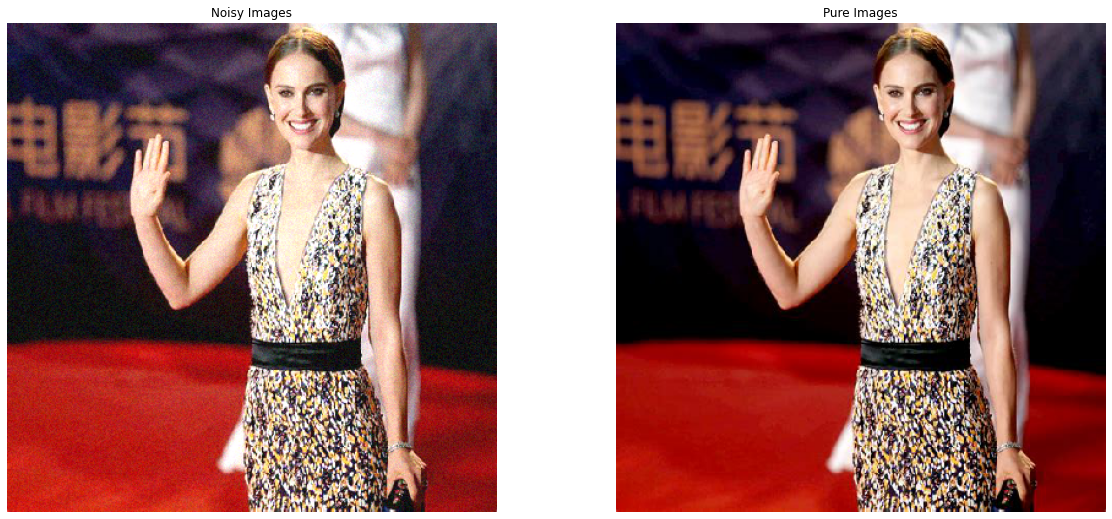

In [ ]:
import matplotlib.pyplot as plt

x,y=next(train_generator)
plt.figure(figsize=(20,9))
plt.subplot(121)
plt.imshow(x[0])
plt.title("Noisy Images")
plt.axis('off')
plt.subplot(122)
plt.imshow(y[0])
plt.title("Pure Images")
plt.axis('off')

In [ ]:
#Validation Data
noisy_datagen = ImageDataGenerator(preprocessing_function=Add_noise,rescale=1/255.)
pure_datagen = ImageDataGenerator(rescale=1/255.)
B_size=8
seed = 1
Size=400
Val_path="celebrity-face-image-dataset/Val"

noisy_generator = noisy_datagen.flow_from_directory(
    Val_path,
    class_mode=None,
    classes=['images'],
    seed=seed,
    color_mode="rgb",
    batch_size=B_size,
    target_size=(Size,Size))

pure_generator = pure_datagen.flow_from_directory(
    Val_path,
    class_mode=None,
    classes=['images'],
    seed=seed,
    color_mode="rgb",
    batch_size=B_size,
    target_size=(Size,Size))
Val_generator=zip(noisy_generator,pure_generator)

Found 180 images belonging to 1 classes.
Found 180 images belonging to 1 classes.


# 2.2 Create Model:

---



In [ ]:
import tensorflow as tf 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,EarlyStopping,Callback
from tensorflow.keras.layers import Conv2D,Dropout,Input,UpSampling2D,BatchNormalization,ZeroPadding2D,concatenate

In [ ]:
def decoder_block(input,skip_features, num_filters,conv_padding=False,zero_pad=False):

    x=  UpSampling2D(size = (2,2))(input)

    if zero_pad == True:
      x=ZeroPadding2D((1,1))(x)
    
    if conv_padding ==True:
        x=Conv2D(num_filters, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(x)
    else:
        x=Conv2D(num_filters, 2, activation = 'relu', kernel_initializer = 'he_normal')(x)
   
    x=Conv2D(num_filters, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(x)
    x = concatenate([x, skip_features],axis=-1)
    x=BatchNormalization()(x)    
    x=Dropout(.2)(x)
    return x

In [ ]:
def autoencoder(input_size):
    """ Input """
    inp = Input(input_size)
    """ Encoder """
    Basemodel= ResNet50(include_top=False, weights='imagenet', input_tensor=inp)

    E1=Basemodel.get_layer("conv1_conv").output 
    E2=Basemodel.get_layer("conv2_block2_3_conv").output 
    E3=Basemodel.get_layer("conv3_block4_3_conv").output
    E4=Basemodel.get_layer("conv4_block6_3_conv").output    

    """bridge"""
    E5=Basemodel.get_layer("conv5_block3_out").output
    
    """ Decoder """

    D1=decoder_block(E5,E4,1024)

    D2=decoder_block(D1,E3,512,conv_padding=True)

    D3=decoder_block(D2,E2,256,conv_padding=True)    
    
    D4=decoder_block(D3,E1,64,conv_padding=True)
    D5=  UpSampling2D(size = (2,2))(D4)
    D5=Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(D5)
    D5=Conv2D(32, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(D5)



    """ OutPut """
    Output=Conv2D(3, 1, activation = 'sigmoid')(D5)
    
    model = Model(inp,Output, name="AE")
    model.summary()
    return model

In [ ]:
model=autoencoder((400,400,3))

94765736/94765736 [==============================] - 0s 0us/step
Model: "AE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 406, 406, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 200, 200, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                

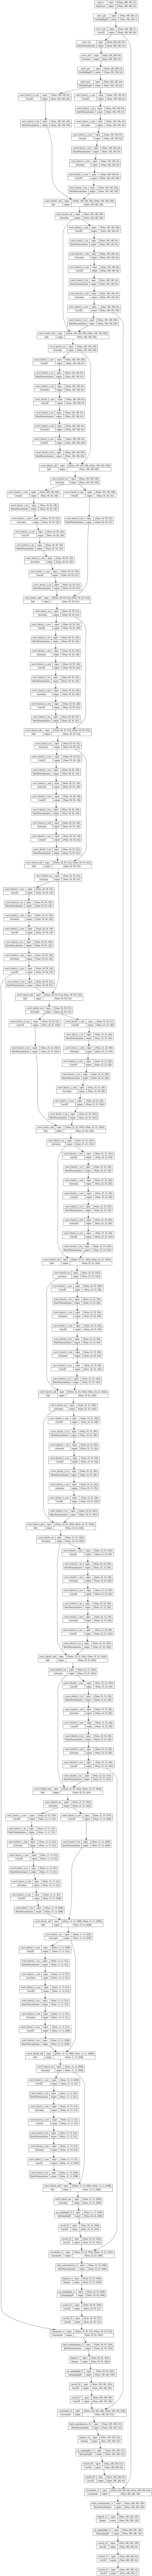

In [ ]:
plot_model(model,show_shapes=True,show_layer_names=True,expand_nested=True)

# 3.1  Callbacks & Trainning:

---


In [ ]:
model.compile(optimizer = Adam(learning_rate = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('AE.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=8, min_lr=1e-8)
Earlystop=EarlyStopping(monitor="val_loss",patience=12,mode="auto",restore_best_weights=True)

In [ ]:
class Viz_process(Callback):  
    def on_epoch_end(self, epoch, logs=None):
        # Select a random sample from the validation set
        image_batch, label_batch = next(Val_generator)
        idx=np.random.randint(image_batch.shape[0])
        image,label=image_batch[idx],label_batch[idx]
        # Get predicted label
        pred_label = np.squeeze(self.model.predict(np.expand_dims(image, axis=0)),axis=0)
        ### Display the image, true label, and predicted label
        plt.figure(figsize=(18,9))
        plt.subplot(131)
        plt.imshow(image)
        plt.axis('off')
        plt.title('noisy-input')
        plt.subplot(132)
        plt.imshow(label)
        plt.axis('off')
        plt.title('Pure-GT')   
        plt.subplot(133)
        plt.imshow(pred_label)
        plt.axis('off')
        plt.title('Predicted')
        plt.show()

In [ ]:
epochs=50
steps=int(1440/B_size)
valid_steps=int(180/B_size)

Hisotry=model.fit(train_generator,
        validation_data=Val_generator,
        steps_per_epoch=steps,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=[Viz_process(),model_checkpoint,reduce_lr,Earlystop])


Epoch 1/20
1/1 [==============================] - 0s 28ms/step


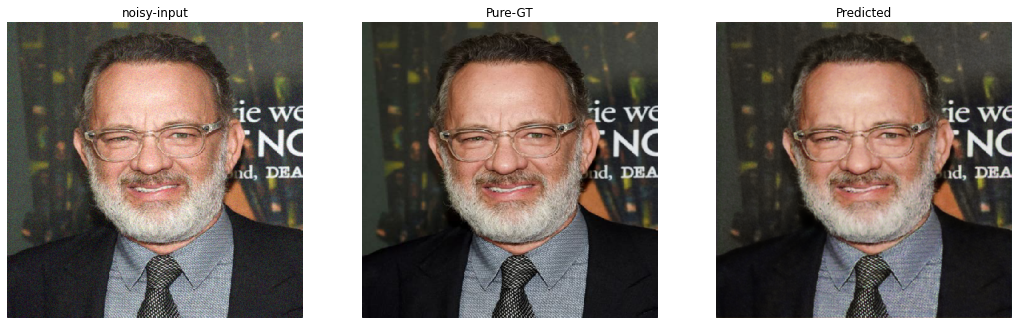


Epoch 1: val_loss improved from inf to 0.45377, saving model to AE1.hdf5
180/180 [==============================] - 265s 1s/step - loss: 0.4670 - accuracy: 0.7988 - val_loss: 0.4538 - val_accuracy: 0.8585 - lr: 1.0000e-05
Epoch 2/20
1/1 [==============================] - 0s 27ms/step


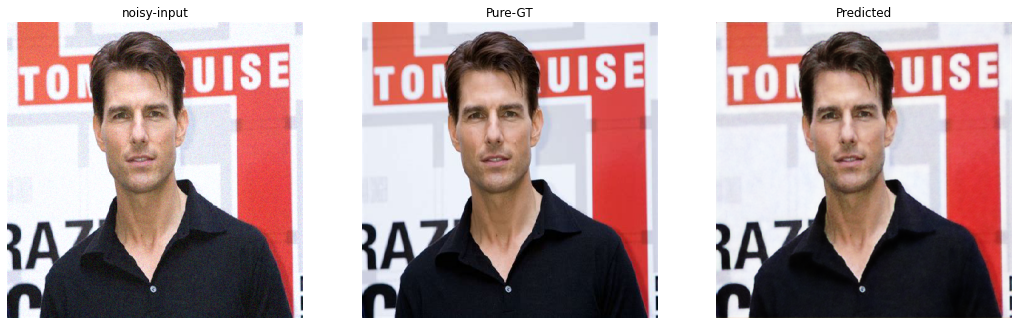


Epoch 2: val_loss did not improve from 0.45377
180/180 [==============================] - 261s 1s/step - loss: 0.4679 - accuracy: 0.7976 - val_loss: 0.4582 - val_accuracy: 0.8565 - lr: 1.0000e-05
Epoch 3/20
1/1 [==============================] - 0s 36ms/step


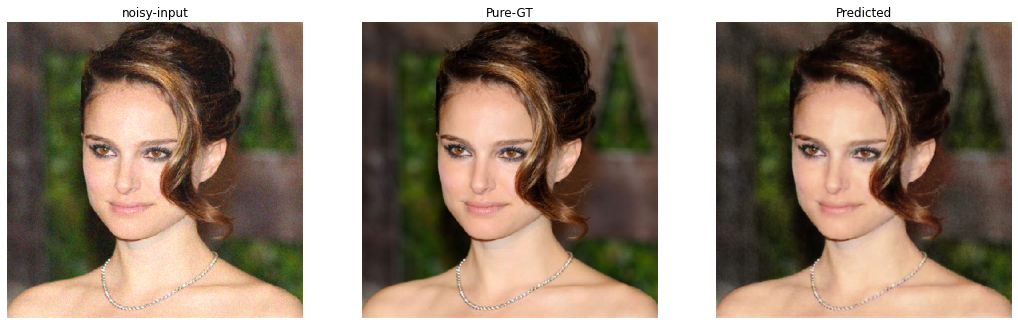


Epoch 3: val_loss improved from 0.45377 to 0.45284, saving model to AE1.hdf5
180/180 [==============================] - 270s 2s/step - loss: 0.4673 - accuracy: 0.8031 - val_loss: 0.4528 - val_accuracy: 0.8678 - lr: 1.0000e-05
Epoch 4/20
1/1 [==============================] - 0s 40ms/step


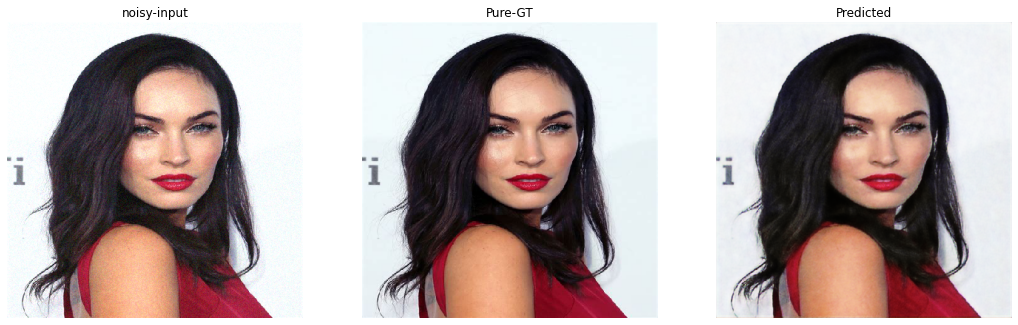


Epoch 4: val_loss did not improve from 0.45284
180/180 [==============================] - 263s 1s/step - loss: 0.4675 - accuracy: 0.8041 - val_loss: 0.4547 - val_accuracy: 0.8600 - lr: 1.0000e-05
Epoch 5/20
1/1 [==============================] - 0s 28ms/step


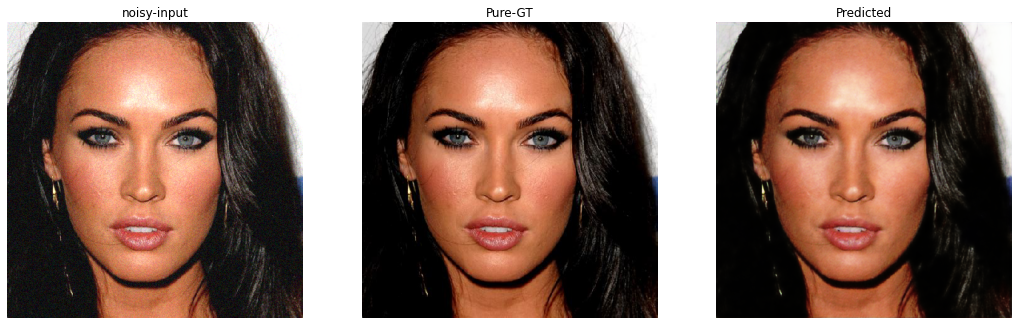


Epoch 5: val_loss did not improve from 0.45284
180/180 [==============================] - 263s 1s/step - loss: 0.4668 - accuracy: 0.8063 - val_loss: 0.4573 - val_accuracy: 0.8628 - lr: 1.0000e-05
Epoch 6/20
1/1 [==============================] - 0s 27ms/step


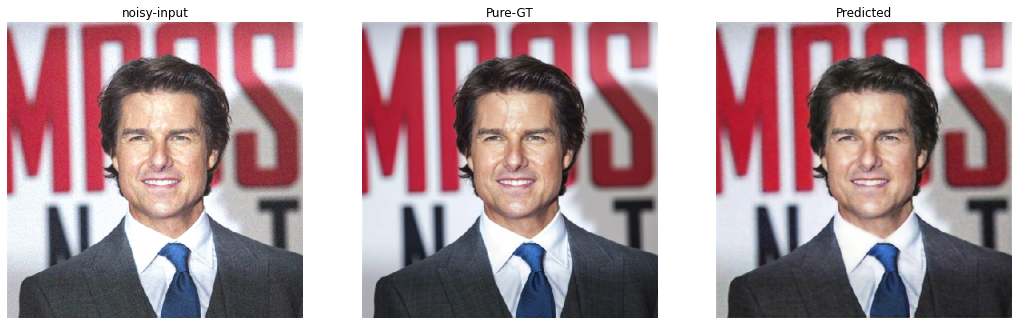


Epoch 6: val_loss did not improve from 0.45284
180/180 [==============================] - 263s 1s/step - loss: 0.4673 - accuracy: 0.8040 - val_loss: 0.4586 - val_accuracy: 0.8604 - lr: 1.0000e-05
Epoch 7/20
 95/180 [==============>...............] - ETA: 1:59 - loss: 0.4706 - accuracy: 0.8129

In [ ]:
epochs=20
steps=int(1440/B_size)
valid_steps=int(180/B_size)

Hisotry=model.fit(train_generator,
        validation_data=Val_generator,
        steps_per_epoch=steps,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=[Viz_process(),model_checkpoint,reduce_lr,Earlystop])

# 3.1  Evaluating & Predicting:

---


In [ ]:
#Test Data
from keras.preprocessing.image import ImageDataGenerator
noisy_datagen = ImageDataGenerator(preprocessing_function=Add_noise,rescale=1/255.)
pure_datagen = ImageDataGenerator(rescale=1/255.)
B_size=8
seed = 1
Size=400
Test_path="celebrity-face-image-dataset/Test"

noisy_generator = noisy_datagen.flow_from_directory(
    Test_path,
    class_mode=None,
    classes=['images'],
    seed=seed,
    color_mode="rgb",
    batch_size=B_size,
    target_size=(Size,Size))

pure_generator = pure_datagen.flow_from_directory(
    Test_path,
    class_mode=None,
    classes=['images'],
    seed=seed,
    color_mode="rgb",
    batch_size=B_size,
    target_size=(Size,Size))
Test_generator=zip(noisy_generator,pure_generator)

Found 180 images belonging to 1 classes.
Found 180 images belonging to 1 classes.


In [ ]:
model.evaluate(Test_generator,steps=len(pure_generator))

23/23 [==============================] - 912s 39s/step - loss: 0.4580 - accuracy: 0.8681


[0.45801717042922974, 0.8681367635726929]

1/1 [==============================] - 5s 5s/step


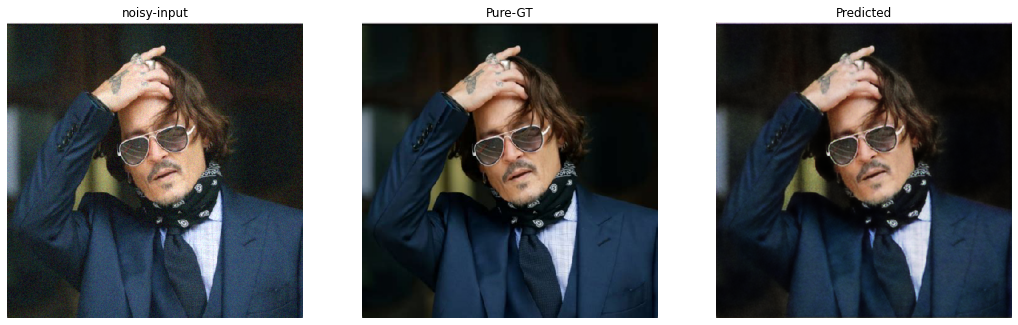

In [ ]:
#predicting:
idx=np.random.randint(8)
x,y=next(Test_generator)
pred=model.predict(np.expand_dims(x[idx],axis=0))
pred=np.squeeze(pred,axis=0)
### Display the image, true label, and predicted label
plt.figure(figsize=(18,9))
plt.subplot(131)
plt.imshow(x[idx])
plt.axis('off')
plt.title('noisy-input')
plt.subplot(132)
plt.imshow(y[idx])
plt.axis('off')
plt.title('Pure-GT')   
plt.subplot(133)
plt.imshow(pred)
plt.axis('off')
plt.title('Predicted')
plt.show()